In [1]:
import pickle
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
import pandas as pd

In [2]:
def mannU_effectsize(stat, nx, ny):
    N = nx + ny
    z = (stat - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
    r = z/ np.sqrt(nx)
    return r

def power_ratio_to_dB(pr):
    dB = 10*np.log10(pr)
    return dB

In [3]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
fig_dir = '/bsuhome/zacharykeskinen/infrasound/figures'
with open(join(result_dir, 'windv3.pkl'), 'rb') as f:
    wind = pickle.load(f)
wind.loc[:, 'broad_power'] = wind.loc[:, 'broad_power']/(60*60*200)
# wind = wind[wind.cor > 0.2]
wind['wind_cat'] = pd.cut(wind['wind'], bins = [-0.1,3,5,11], labels = ['Low Wind (0-3 m/s)','Med Wind (3-5 m/s)','High Wind (5+ m/s)'])
wind['sd_cat'] = pd.cut(wind['sd_delta'], bins = [-2,-0.02,0.0,0.2,2], labels = ['Above Snow','buffer','0-20 cm Burial','20+ cm burial'])
# wind['sd_cat'] = pd.cut(wind['sd_delta'], bins = [-2,0.0,0.2,2], labels = ['Above Snow','0-20 cm Burial','20+ cm burial'])

wind = wind[wind.wind_cat != 'buffer']

In [8]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
#  'figure.facecolor': 'white',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
#  'patch.edgecolor': 'w',
#  'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

## Paper Figure of Wind Speed

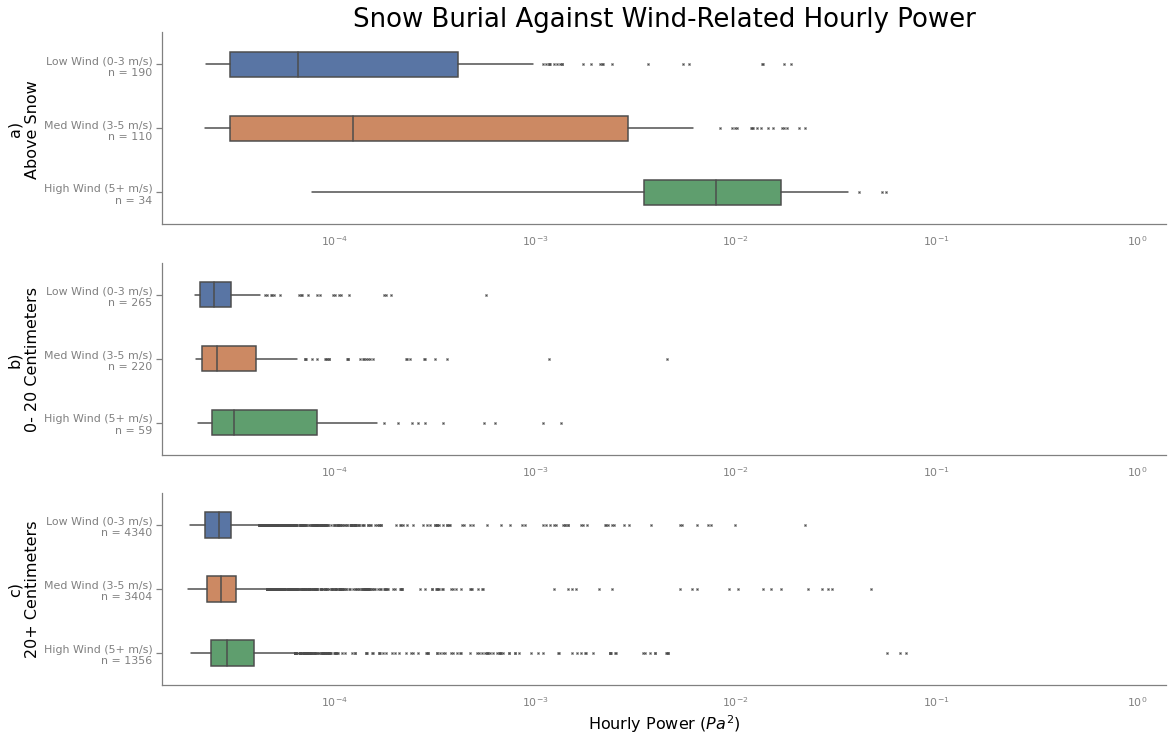

In [11]:
f, axes = plt.subplots(3)
wind_snow = wind.loc[(wind.h != 2.00)].copy()
ylabels = ['a)\nAbove Snow','b)\n0- 20 Centimeters','c)\n20+ Centimeters']
for j, h in enumerate(['Above Snow','0-20 cm Burial','20+ cm burial']):
        plot = wind_snow.loc[(wind_snow.sd_cat == h)]
        ax = sns.boxplot(y = 'wind_cat', x = 'broad_power', data = plot, ax = axes[j], showcaps = False, flierprops={"marker": "x"}, fliersize= 2, width = 0.4)
        low = plot[plot.wind_cat == 'Low Wind (0-3 m/s)']
        med = plot[plot.wind_cat == 'Med Wind (3-5 m/s)']
        high = plot[plot.wind_cat == 'High Wind (5+ m/s)']
        labels = [f"Low Wind (0-3 m/s)\nn = {len(low)}",f"Med Wind (3-5 m/s)\nn = {len(med)}",f"High Wind (5+ m/s)\nn = {len(high)}"]
        ax.set_yticklabels(labels)
        ax.set_ylabel(ylabels[j])
        if j == 0:
            ax.set_title('Snow Burial Against Wind-Related Hourly Power')
        if j == 2:
            ax.set_xlabel('Hourly Power ($Pa^{2}$)')
        else:
            ax.set_xlabel('')
            ax.set_xticks([])
        ax.set_xscale('log')
        ax.set_xlim(10/(60*60*200), 10e5/(60*60*200))
plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/wind','boxplot_wind_depth_binv5'), dpi = 300)

## P Test

In [6]:
from scipy.stats import normaltest
for cat in wind_snow.wind_cat.unique():
    a = normaltest(wind.loc[wind.wind_cat == cat, 'broad_power'].values)
    if a.pvalue < 0.001:
        print(f"Wind cat {cat} is not normally distributed")

Wind cat Low Wind (0-3 m/s) is not normally distributed
Wind cat Med Wind (3-5 m/s) is not normally distributed
Wind cat High Wind (5+ m/s) is not normally distributed


In [7]:
from itertools import combinations
from scipy.stats import mannwhitneyu
for sd_cat in wind_snow.sd_cat.unique():
    for cat1, cat2 in combinations(wind.wind_cat.unique(), 2):
        v1 = wind_snow.loc[(wind_snow.sd_cat == sd_cat) & (wind_snow.wind_cat == cat1), 'broad_power'].values
        v2 = wind_snow.loc[(wind_snow.sd_cat == sd_cat) & (wind_snow.wind_cat == cat2), 'broad_power'].values
        res = mannwhitneyu(v1, v2)
        print(f"At sd {sd_cat}. The pvalue for {cat1} and {cat2} is {res.pvalue}")
        print(f"The group sizes are {len(v1)} and {len(v2)}")
        effect_size = mannU_effectsize(res.statistic, len(v1), len(v2))
        print(f"median 1: {np.median(v1)}. median 2: {np.median(v2)}")
        print(f"The effect size of {cat1} vs {cat2} is {effect_size}")
        dB = power_ratio_to_dB(np.median(v1)/np.median(v2))
        print(f"The power ratio is {dB} dB")
        print("-".center(20, "-"))

At sd 0-20 cm Burial. The pvalue for Low Wind (0-3 m/s) and Med Wind (3-5 m/s) is 0.01413600307853921
The group sizes are 265 and 220
median 1: 2.5160090928170846e-05. median 2: 2.6159909118520155e-05
The effect size of Low Wind (0-3 m/s) vs Med Wind (3-5 m/s) is -0.15075502826185025
The power ratio is -0.16924024573895805 dB
--------------------
At sd 0-20 cm Burial. The pvalue for Low Wind (0-3 m/s) and High Wind (5+ m/s) is 9.626553942873143e-07
The group sizes are 265 and 59
median 1: 2.5160090928170846e-05. median 2: 3.1813121119587763e-05
The effect size of Low Wind (0-3 m/s) vs High Wind (5+ m/s) is -0.3009979128066063
The power ratio is -1.018940726224951 dB
--------------------
At sd 0-20 cm Burial. The pvalue for Med Wind (3-5 m/s) and High Wind (5+ m/s) is 0.0008747699991486507
The group sizes are 220 and 59
median 1: 2.6159909118520155e-05. median 2: 3.1813121119587763e-05
The effect size of Med Wind (3-5 m/s) vs High Wind (5+ m/s) is -0.22443386576551969
The power ratio is

In [8]:
from itertools import combinations
from scipy.stats import mannwhitneyu
for wind_cat in wind_snow.wind_cat.unique():
    for cat1, cat2 in combinations(wind.sd_cat.unique(), 2):
        v1 = wind_snow.loc[(wind_snow.sd_cat == cat1) & (wind_snow.wind_cat == wind_cat), 'broad_power'].values
        v2 = wind_snow.loc[(wind_snow.sd_cat == cat2) & (wind_snow.wind_cat == wind_cat), 'broad_power'].values
        res = mannwhitneyu(v1, v2)
        print(f"At wind {wind_cat}. The pvalue for {cat1} and {cat2} is {res.pvalue}")
        print(f"The group sizes are {len(v1)} and {len(v2)}")
        effect_size = mannU_effectsize(res.statistic, len(v1), len(v2))
        print(f"median 1: {np.median(v1)}. median 2: {np.median(v2)}")
        print(f"The effect size of {cat1} vs {cat2} is {effect_size}")
        dB = power_ratio_to_dB(np.median(v1)/np.median(v2))
        print(f"The power ratio is {dB} dB")
        print("-".center(20, "-"))

At wind Low Wind (0-3 m/s). The pvalue for 0-20 cm Burial and Above Snow is 2.0635756054124906e-37
The group sizes are 265 and 190
median 1: 2.5160090928170846e-05. median 2: 6.632731908248456e-05
The effect size of 0-20 cm Burial vs Above Snow is -0.785221805564524
The power ratio is -4.209802373749651 dB
--------------------
At wind Low Wind (0-3 m/s). The pvalue for 0-20 cm Burial and 20+ cm burial is 0.02046781858964473
The group sizes are 265 and 4340
median 1: 2.5160090928170846e-05. median 2: 2.6724556688847963e-05
The effect size of 0-20 cm Burial vs 20+ cm burial is -0.14237417032047497
The power ratio is -0.261983034858963 dB
--------------------
At wind Low Wind (0-3 m/s). The pvalue for 0-20 cm Burial and buffer is 0.9782689387400846
The group sizes are 265 and 32
median 1: 2.5160090928170846e-05. median 2: 2.3064953010758333e-05
The effect size of 0-20 cm Burial vs buffer is 0.0017402233041297816
The power ratio is 0.3775963213383393 dB
--------------------
At wind Low Win

# Play below

In [9]:
tmp_dir = join(result_dir,'tmp')
super_x = []
for f in glob(join(tmp_dir, '*')):
    with open(f, 'rb') as f:
        df = pickle.load(f)
    super_x.append(df)
res = pd.concat(super_x)
res['wind_cat'] = pd.cut(res['wind'], bins = [-0.1,3,5,11], labels = ['low-wind','med-wind','high-wind'])
with open(join(result_dir, 'windv2.pkl'), 'wb') as f:
    pickle.dump(res, f)

In [10]:
wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
# wind = wind.loc[wind.cor < wind.cor.quantile(0.8)]
# wind = wind.loc[wind.wind > 6]
# wind = wind.drop(['power'], axis = 1)
powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]
#powers.loc[powers.sd_delta < -0.5, 'sd_delta'] = -0.5
plot = powers.drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]

In [11]:
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]
plot = pd.DataFrame()
for low, high in levels:
    d = {}
    if low == None:
        sub = powers.loc[powers.sd_delta < high]
        low = -0.2
    elif high == None:
        sub = powers.loc[powers.sd_delta > low]
    else:
        sub = powers.loc[(powers.sd_delta > low) & (powers.sd_delta < high)]
    sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
    sub.index = np.round(sub.index.astype(float),2)
    d[low] = sub
    plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)

In [12]:
from re import A


f, axes = plt.subplots(3, figsize= (12,8))
levels = [[None,0],[0,0.2],[0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1],[1,1.2],[1.2,None]]

for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    power_sub = powers.loc[(powers.wind < high) & (powers.wind > low)]
    plot = pd.DataFrame()
    for low, high in levels:
        d = {}
        if low == None:
            sub = power_sub.loc[power_sub.sd_delta < high]
            low = -0.2
        elif high == None:
            sub = power_sub.loc[power_sub.sd_delta > low]
        else:
            sub = power_sub.loc[(power_sub.sd_delta > low) & (power_sub.sd_delta < high)]
        sub = sub.drop(['sd_delta', 'cor', 'wind'], axis = 1).dropna().mean()
        sub.index = np.round(sub.index.astype(float),2)
        d[low] = sub
        plot = pd.concat([plot, pd.DataFrame.from_dict(d)], axis = 1)
    im = ax.imshow(plot[::-1], aspect = 'auto',vmin=-0.0000005, vmax=0.000003, interpolation = 'bilinear',extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1]))
    plt.colorbar(im, ax= ax)

Error in callback <function flush_figures at 0x2aab082b61f0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
from matplotlib.colors import LogNorm
f, axes = plt.subplots(3, figsize= (12,8))
norm=LogNorm(vmin=1e-7, vmax=2e-5)
title_dic = {'0-3':'Low Wind Speeds', '3-5':'Medium Wind Speeds', '5-10':'High Wind Speeds'}
for i, (low, high) in enumerate([[0,3],[3,5],[5,10]]):
    ax = axes[i]
    with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
        wind = pickle.load(f)
    wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
    # wind = wind.loc[wind.cor < wind.cor.quantile(0.5)]
    wind.loc[wind.sd_delta < -0.2, 'sd_delta'] = -0.2
    powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
    powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]

    plot = powers.loc[(powers.wind < high) & (powers.wind > low)].drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()
    new_index = np.linspace(plot.index[0], plot.index[-1], len(plot))
    #df_resampled = plot.reindex(plot.index.union(new_index)).interpolate(method='nearest').loc[new_index]
    df_resampled = plot.reindex(np.arange(-0.2, 1, 0.1), method = 'nearest')
    extent = (df_resampled.index[0], df_resampled.index[-1], df_resampled.columns[0], df_resampled.columns[-1])
    # extent = (-0.2,1,0,100)
    im = ax.imshow(df_resampled.T.iloc[::-1],extent = extent, aspect = 'auto', norm = norm, interpolation = None)
    ax.set_ylabel('Frequency (Hz)')
    title = title_dic[f'{low}-{high}']
    # ax.set_title(f'Wind Speeds from {low} to {high} m/s')
    ax.set_title(title)
    plt.colorbar(im, ax = ax)
axes[2].set_xlabel('Sensor Burial Depth (m)')
#plt.xlim(-0.2,0.5)
plt.tight_layout()

## scatter plots

In [ ]:
plt.subplots(figsize = (12,8))
plt.scatter(wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].wind, wind[(wind.sd_delta < -0.1) & (wind.cor > 0)].broad_power)
plt.yscale('log')
plt.ylabel('Hourly Power')
plt.xlabel('Hourly Average Wind Speed')
plt.title('Canyon Creek Hourly Wind Speed vs Banner "Free-Air" Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-scatter.png'))

In [ ]:

sns.catplot(data = wind[(wind.h != 2) & (wind.sd_delta < -0.1)], x = 'wind_cat', y = 'broad_power', kind = 'box', height=8.27, aspect=11.7/8.27)
plt.yscale('log')
plt.ylabel('Banner Free-Air Power')
plt.xlabel('')
plt.xticks(ticks = [0,1,2], labels = ['Low Wind','Medium Wind','High Wind'])
plt.title('Canyon Wind Speeds vs Free-Air Banner Power')
plt.savefig(join(fig_dir, 'wind','free-air-canyon-box.png'))

In [ ]:
from sklearn.linear_model import LinearRegression
plt.subplots(figsize = (12,8))
for i, (low, high) in enumerate([[0,3],[5,10]]):
    # if i == 2:
        plot = wind.loc[(wind.wind < high) & (wind.wind > low) & (wind.cor > 0.2)]
        plt.scatter(plot.sd_delta, plot.broad_power, label = f'{low}-{high} m/s wind speed', alpha = 0.4)
        reg = LinearRegression().fit(plot.sd_delta.values.reshape(-1, 1), plot.broad_power.values.reshape(-1, 1))
        x = np.linspace(-0.5, 1.7, 1000)
        y = reg.predict(x.reshape(-1, 1))
        plt.plot(x,y)

plt.legend()
plt.yscale('log')
plt.ylim(10e0, 8e3)
plt.ylabel('Hourly Power')
plt.xlabel('Burial Depth')
plt.title('Hourly Power vs Burial Depth')
plt.savefig(join(fig_dir, 'wind','scatter_power_depth.png'))

## Scatter of air vs buried

In [ ]:
d = pd.to_datetime('2001-02-01')
d = d.tz_localize('UTC')
t = [d + pd.Timedelta(f'{si} hours') for si in range(24)]
t_local = [t.tz_convert('America/Boise') for t in t]
# t_hour = [t.time() for t in t_local]
for i, d in enumerate(t_local):
    if d.day == 31:
        t_local[i] = t_local[i] + pd.Timedelta('1 day')

with open('/bsuhome/zacharykeskinen/infrasound/results/hourly_average/v1', 'rb') as f:
    hourly = pickle.load(f)

hour_power = pd.DataFrame(hourly, index= t_local, columns = [0.33,0.66,1,1.33,2.0])
hour_power = hour_power.sort_index()

: 

In [ ]:
canyon = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/snotel/canyon_wx.csv', comment = '#', parse_dates=['Date_Time'], index_col = ['Date_Time'])
units = canyon.iloc[0]
canyon = canyon.iloc[1:]
# convert all columns of DataFrame
canyon = canyon.apply(pd.to_numeric, errors = 'ignore')
canyon = canyon.loc[:pd.to_datetime('2022-05-15')]
canyon = canyon.tz_convert('UTC')

In [ ]:
s = canyon.loc[(canyon.index > pd.to_datetime('2022-01-01T00:00:00 UTC')) & (canyon.index < pd.to_datetime('2022-04-01T00:00:00 UTC')), 'wind_speed_set_1']

: 

In [ ]:
import matplotlib.dates as mdates
from dateutil import tz
fig, ax = plt.subplots()
for col in hour_power.columns:
    sns.lineplot(x = hour_power.index, y = col, data = hour_power, ax = ax, label = f'{col} m')
plt.yscale('log')
plt.title('Average Power for Buried vs Free-Air Stations')
plt.ylabel('Hourly Power ($Pa^{2}$)')
plt.xlabel('Time of Day')
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7, integer = True))
myFmt = mdates.DateFormatter('%H:%M', tz = tz.gettz('America/Boise'))

ax.xaxis.set_major_formatter(myFmt)
# ax.xaxis.set_major_locator(mdates.HourLocator())
# fig.autofmt_xdate()

In [ ]:
# f, axes = plt.subplots(3)
# wind_snow = wind.loc[(wind.h != 2.00) & (wind.cor < 1)].copy()
# wind_snow.loc[:, 'broad_power'] = wind_snow.loc[:, 'broad_power']/(60*60*200)
# ylabels = ['Above Snow','0- 20 Centimeters','20+ Centimeters']
# for j, h in enumerate([-0.02, (-0.02, 0.2), 0.2]):
#         if j == 0:
#             plot = wind_snow.loc[(wind_snow.sd_delta < h)]
#         if j == 1:
#             ax = plot = wind_snow.loc[(wind_snow.sd_delta > h[0]) & (wind_snow.sd_delta < h[1])]
#         if j == 2:
#             plot = wind_snow.loc[(wind_snow.sd_delta > h)]
        
#         # plot.loc[:,'broad_power'] = (plot['broad_power']/(60*60)).values
#         ax = sns.boxplot(y = 'wind_cat', x = 'broad_power', data = plot, ax = axes[j], showcaps = False, flierprops={"marker": "x"}, fliersize= 2, width = 0.4)

#         ax.set_ylabel(ylabels[j])
#         if j == 0:
#             ax.set_title('Burial Depth vs Hourly Power')
#         if j == 2:
#             ax.set_xlabel('Hourly Power ($Pa^{2}$)')
#         else:
#             ax.set_xlabel('')
#             ax.set_xticks([])
#         ax.set_xscale('log')
#         ax.set_xlim(10/(60*60*200), 10e5/(60*60*200))
# plt.savefig(join('/bsuhome/zacharykeskinen/infrasound/figures/wind','boxplot_wind_depth_binv4'), dpi = 300)